#Important libraries

In [65]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx


TYPE_COL = "categories"

In [66]:
# ---------------------------------------------------
# CATEGORY GROUPING
# ---------------------------------------------------
def map_main_category(raw):
    if pd.isna(raw):
        return "Unknown"
    text = str(raw).lower()

    if any(k in text for k in ["coffee", "cafe", "café", "espresso"]):
        return "Coffee Shop"

    if any(k in text for k in ["restaurant", "shawarma", "burger", "pizza", "food"]):
        return "Restaurant"

    return "Other"


In [ ]:
# ---------------------------------------------------
# LOAD DATA
# ---------------------------------------------------
def load_data(path, label):
    gdf = gpd.read_file(path)

    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)

    gdf["main_category"] = gdf[TYPE_COL].apply(map_main_category)

    print(f"\n[INFO] Loaded {label}: {len(gdf)} points")
    return gdf


In [ ]:
# ---------------------------------------------------
# SUMMARY (PRINT ONLY)
# ---------------------------------------------------
def summarize(gdf, label):
    total = len(gdf)
    restaurants = (gdf["main_category"] == "Restaurant").sum()
    coffees = (gdf["main_category"] == "Coffee Shop").sum()

    print(f"\n========== SUMMARY: {label} ==========")
    print(f"Total points: {total}")
    print(f"Restaurants : {restaurants} ({restaurants/total*100:.2f}%)")
    print(f"Coffee Shops: {coffees} ({coffees/total*100:.2f}%)")
    print("=======================================\n")

    return {
        "total": total,
        "restaurants": restaurants,
        "coffees": coffees,
    }



In [67]:
# ---------------------------------------------------
# COMPARISON
# ---------------------------------------------------
def compare(full, area):
    print("\n================= COMPARISON =================")

    rest_full = full["restaurants"] / full["total"]
    rest_area = area["restaurants"] / area["total"]

    coffee_full = full["coffees"] / full["total"]
    coffee_area = area["coffees"] / area["total"]

    print("\n--- Restaurants ---")
    print(f"Riyadh:   {rest_full*100:.2f}%")
    print(f"Area:     {rest_area*100:.2f}%")
    print("→ Area has HIGHER restaurant concentration!" if rest_area > rest_full else
          "→ Area has LOWER restaurant concentration.")

    print("\n--- Coffee Shops ---")
    print(f"Riyadh:   {coffee_full*100:.2f}%")
    print(f"Area:     {coffee_area*100:.2f}%")
    print("→ Area has HIGHER coffee shop concentration!" if coffee_area > coffee_full else
          "→ Area has LOWER coffee shop concentration.")

    print("\n================================================\n")


In [68]:

# ---------------------------------------------------
# PLOTTING FUNCTIONS (NO SAVE)
# ---------------------------------------------------

def plot_points(gdf, label):
    plt.figure(figsize=(12, 10))
    base = gdf.plot(color="lightgray", markersize=1, alpha=0.3)

    gdf[gdf["main_category"] == "Restaurant"].plot(ax=base, color="red", markersize=5, label="Restaurants")
    gdf[gdf["main_category"] == "Coffee Shop"].plot(ax=base, color="brown", markersize=5, label="Coffee Shops")

    plt.title(f"Restaurants & Coffee Shops – {label}")
    plt.legend()
    plt.show()


def plot_hexbin(gdf, label):
    plt.figure(figsize=(10, 8))
    plt.hexbin(gdf.geometry.x, gdf.geometry.y, gridsize=60, cmap="Reds", mincnt=1)
    plt.colorbar(label="Density")
    plt.title(f"Density (Hexbin) – {label}")
    plt.show()


def plot_kde(gdf, label):
    from scipy.stats import gaussian_kde

    xs = gdf.geometry.x.values
    ys = gdf.geometry.y.values
    kde = gaussian_kde([xs, ys])

    xgrid = np.linspace(xs.min(), xs.max(), 300)
    ygrid = np.linspace(ys.min(), ys.max(), 300)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    plt.figure(figsize=(10, 8))
    plt.imshow(Z, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               cmap="hot", origin="lower", alpha=0.7)
    plt.colorbar(label="Density")
    plt.title(f"KDE Density – {label}")
    plt.show()


In [69]:
import matplotlib.pyplot as plt

def plot_hist_comparison(full, area):
    """
    Plots histogram comparison between:
        - Restaurants (Full Riyadh vs Selected Area)
        - Coffee Shops (Full Riyadh vs Selected Area)
    """

    # ---- FILTER DATA ----
    full_rest = full[full["main_category"] == "Restaurant (Other)"]
    full_coffee = full[full["main_category"] == "Coffee Shop"]

    area_rest = area[area["main_category"] == "Restaurant (Other)"]
    area_coffee = area[area["main_category"] == "Coffee Shop"]

    # ---- CREATE HISTOGRAM ----
    labels = ["Restaurants", "Coffee Shops"]
    full_counts  = [len(full_rest), len(full_coffee)]
    area_counts  = [len(area_rest), len(area_coffee)]

    x = range(len(labels))
    width = 0.35  # bar width

    plt.figure(figsize=(10,6))
    plt.bar([i - width/2 for i in x], full_counts, width=width, label="Full Riyadh", color="#1f77b4")
    plt.bar([i + width/2 for i in x], area_counts, width=width, label="Selected Area", color="#ff7f0e")

    # ---- LABELS ----
    plt.xticks(x, labels, fontsize=12)
    plt.ylabel("Number of Places", fontsize=12)
    plt.title("Comparison of Restaurants & Coffee Shops\nFull Riyadh vs Selected Area", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    plt.show()

    # ---- PRINT SUMMARY ----
    print("\n----- SUMMARY -----")
    print(f"Full Riyadh - Restaurants:     {len(full_rest)}")
    print(f"Full Riyadh - Coffee Shops:    {len(full_coffee)}")
    print(f"Selected Area - Restaurants:   {len(area_rest)}")
    print(f"Selected Area - Coffee Shops:  {len(area_coffee)}")

    # Percentages inside selected area relative to full Riyadh
    print("\n----- PERCENTAGE in Selected Area (relative to all Riyadh) -----")
    print(f"Restaurants: {len(area_rest)/len(full_rest)*100:.2f}%")
    print(f"Coffee Shops: {len(area_coffee)/len(full_coffee)*100:.2f}%")



In [75]:
# -------- CONFIG --------
FULL_FILE = "/content/sample_data/rrc.geojson"    # all Riyadh
AREA_FILE = "/content/sample_data/rrc.geojson"   # your selected area

TYPE_COL = "categories"
LAT_COL  = "lat"
LON_COL  = "lng"

OUT_DIR = "maps_with_roads"
os.makedirs(OUT_DIR, exist_ok=True)


# -------- CATEGORY MAPPING --------

def map_main_category(raw):
    if pd.isna(raw):
        return "Unknown"

    text = str(raw).lower()

    # coffee
    if any(k in text for k in ["coffee shop", "café", "cafe", "coffee roaster", "espresso"]):
        return "Coffee Shop"

    # everything that contains the word restaurant
    if "restaurant" in text:
        return "Restaurant"

    return "Other"


def load_and_prepare(path, label):
    print(f"\n[LOAD] {label}: {path}")
    gdf = gpd.read_file(path)

    # ensure CRS
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)
    else:
        gdf = gdf.to_crs(epsg=4326)

    if TYPE_COL in gdf.columns:
        gdf["main_category"] = gdf[TYPE_COL].apply(map_main_category)
    else:
        gdf["main_category"] = "Unknown"

    if "geometry" not in gdf.columns or gdf.geometry.isna().any():
        gdf["geometry"] = gpd.points_from_xy(gdf[LON_COL], gdf[LAT_COL], crs="EPSG:4326")

    print(f"[INFO] {label}: {len(gdf)} points")
    return gdf


def filter_coffee_and_restaurants(gdf):
    is_coffee = gdf["main_category"] == "Coffee Shop"
    is_rest   = gdf["main_category"] == "Restaurant"
    return gdf[is_coffee | is_rest].copy()


# -------- STATS --------

def print_summary(name, gdf_all, gdf_food):
    total_points = len(gdf_all)
    total_food   = len(gdf_food)

    n_coffee = (gdf_food["main_category"] == "Coffee Shop").sum()
    n_rest   = (gdf_food["main_category"] == "Restaurant").sum()

    print(f"\n===== {name} =====")
    print(f"Total places (all categories): {total_points}")
    print(f"Total coffee + restaurants   : {total_food}")
    if total_points > 0:
        print(f"→ Food share in all places   : {100*total_food/total_points:.1f}%")

    if total_food > 0:
        print(f"Coffee shops : {n_coffee} ({100*n_coffee/total_food:.1f}%)")
        print(f"Restaurants  : {n_rest} ({100*n_rest/total_food:.1f}%)")


# -------- PLOTTING WITH BASEMAP --------

def plot_with_basemap(gdf_4326, city_bounds_4326, title, out_name):
    """
    Plot coffee & restaurants for gdf_4326 on top of a basemap.
    The map frame is the full Riyadh bounds (city_bounds_4326).
    """
    if gdf_4326.empty:
        print(f"[PLOT] No points for {title}")
        return

    # project everything to Web Mercator for contextily
    gdf = gdf_4326.to_crs(epsg=3857)

    # convert Riyadh bounds to 3857 as well
    bbox_4326 = gpd.GeoSeries([box(*city_bounds_4326)], crs=4326)
    minx, miny, maxx, maxy = bbox_4326.to_crs(epsg=3857).total_bounds

    is_coffee = gdf["main_category"] == "Coffee Shop"
    is_rest   = gdf["main_category"] == "Restaurant"

    x_coffee = gdf.loc[is_coffee, "geometry"].x
    y_coffee = gdf.loc[is_coffee, "geometry"].y
    x_rest   = gdf.loc[is_rest, "geometry"].x
    y_rest   = gdf.loc[is_rest, "geometry"].y

    fig, ax = plt.subplots(figsize=(8, 8), dpi=120)

    # restaurants – brown-ish
    ax.scatter(x_rest, y_rest,
               s=8, alpha=0.75, color="#8B4513",
               label="Restaurants")

    # coffee shops – red
    ax.scatter(x_coffee, y_coffee,
               s=14, alpha=0.85, color="#FF4B5C",
               label="Coffee shops")

    # set Riyadh-wide frame
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # add basemap (roads, neighborhoods)
    ctx.add_basemap(
        ax,
        crs="EPSG:3857",
        source=ctx.providers.CartoDB.Positron,  # light grey roads
        zoom=11                                  # adjust if you want more/less detail
    )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    ax.legend(loc="upper right")

    out_path = os.path.join(OUT_DIR, out_name)
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()
    print(f"[PLOT] Saved: {out_path}")



[INFO] Loaded Full Riyadh: 19355 points

[INFO] Loaded Selected Area: 1766 points

========== SUMMARY: Full Riyadh ==========
Total points: 19355
Restaurants : 6161 (31.83%)
Coffee Shops: 5180 (26.76%)


========== SUMMARY: Selected Area ==========
Total points: 1766
Restaurants : 498 (28.20%)
Coffee Shops: 579 (32.79%)


================= COMPARISON =================

--- Restaurants ---
Riyadh:   31.83%
Area:     28.20%
→ Area has LOWER restaurant concentration.

--- Coffee Shops ---
Riyadh:   26.76%
Area:     32.79%
→ Area has HIGHER coffee shop concentration!



===== All Riyadh =====
Total places (all categories): 19355
Total coffee + restaurants   : 11341
→ Food share in all places   : 58.6%
Coffee shops : 5180 (45.7%)
Restaurants  : 6161 (54.3%)

===== Selected Area =====
Total places (all categories): 1766
Total coffee + restaurants   : 1077
→ Food share in all places   : 61.0%
Coffee shops : 579 (53.8%)
Restaurants  : 498 (46.2%)
[PLOT] Saved: maps_with_roads/All_Riyadh_food_

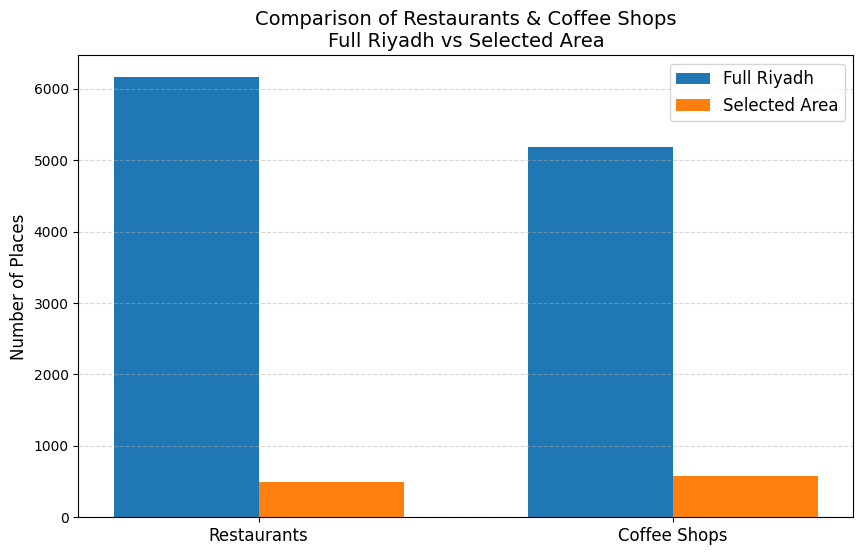


----- SUMMARY -----
Full Riyadh - Restaurants:     6161
Full Riyadh - Coffee Shops:    5180
Selected Area - Restaurants:   498
Selected Area - Coffee Shops:  579

----- PERCENTAGE in Selected Area (relative to all Riyadh) -----
Restaurants: 8.08%
Coffee Shops: 11.18%


In [76]:
def plot_hist_comparison(full, area):
    """
    Plots histogram comparison between:
        - Restaurants (Full Riyadh vs Selected Area)
        - Coffee Shops (Full Riyadh vs Selected Area)
    """

    # ---- FILTER DATA ----
    full_rest = full[full["main_category"] == "Restaurant"]
    full_coffee = full[full["main_category"] == "Coffee Shop"]

    area_rest = area[area["main_category"] == "Restaurant"]
    area_coffee = area[area["main_category"] == "Coffee Shop"]

    # ---- CREATE HISTOGRAM ----
    labels = ["Restaurants", "Coffee Shops"]
    full_counts  = [len(full_rest), len(full_coffee)]
    area_counts  = [len(area_rest), len(area_coffee)]

    x = range(len(labels))
    width = 0.35  # bar width

    plt.figure(figsize=(10,6))
    plt.bar([i - width/2 for i in x], full_counts, width=width, label="Full Riyadh", color="#1f77b4")
    plt.bar([i + width/2 for i in x], area_counts, width=width, label="Selected Area", color="#ff7f0e")

    # ---- LABELS ----
    plt.xticks(x, labels, fontsize=12)
    plt.ylabel("Number of Places", fontsize=12)
    plt.title("Comparison of Restaurants & Coffee Shops\nFull Riyadh vs Selected Area", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    plt.show()

    # ---- PRINT SUMMARY ----
    print("\n----- SUMMARY -----")
    print(f"Full Riyadh - Restaurants:     {len(full_rest)}")
    print(f"Full Riyadh - Coffee Shops:    {len(full_coffee)}")
    print(f"Selected Area - Restaurants:   {len(area_rest)}")
    print(f"Selected Area - Coffee Shops:  {len(area_coffee)}")

    # Percentages inside selected area relative to full Riyadh
    print("\n----- PERCENTAGE in Selected Area (relative to all Riyadh) -----")
    print(f"Restaurants: {len(area_rest)/len(full_rest)*100:.2f}%")
    print(f"Coffee Shops: {len(area_coffee)/len(full_coffee)*100:.2f}%")

# ---------------------------------------------------
# MAIN
# ---------------------------------------------------
if __name__ == "__main__":
    full = load_data("/content/sample_data/rrc.geojson", "Full Riyadh")
    area = load_data("/content/sample_data/rsd2.geojson", "Selected Area")

    full_info = summarize(full, "Full Riyadh")
    area_info = summarize(area, "Selected Area")

    compare(full_info, area_info)


    # city bounds in EPSG:4326 (lat/lng)
    city_bounds_4326 = full.total_bounds  # [minx, miny, maxx, maxy]

    # filter to coffee + restaurants
    full_food = filter_coffee_and_restaurants(full)
    area_food = filter_coffee_and_restaurants(area)

    # stats
    print_summary("All Riyadh", full, full_food)
    print_summary("Selected Area", area, area_food)

    # plots with visible roads
    plot_with_basemap(
        full_food,
        city_bounds_4326,
        "Coffee & Restaurants – All Riyadh",
        "All_Riyadh_food_roads.png"
    )

    plot_with_basemap(
        area_food,
        city_bounds_4326,  # same frame, only points inside box
        "Coffee & Restaurants – Selected Area (Riyadh frame)",
        "SelectedArea_food_roads.png"
    )

    print("\n[DONE] Maps with roads created.")

    plot_hist_comparison(full, area)
